# Assignment 1: Titanic Survival Prediction


I shall be implementing Naive Bayes and KNN algorithms to predict Titanic passenger survival.

**Dataset:**  
- `train.csv`: Training data with survival labels  
- `test.csv`: Test data without labels  
- `gender_submission.csv`: True labels for test data  


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/test.csv')
gender_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/gender_submission.csv')


### 1. Data Visualization

First Visualizing key features to understand patterns in survival rates:
- **Survival Count:** How many passengers survived vs. died  
- **Survival by Class:** Impact of passenger class (Pclass)  
- **Survival by Sex:** Gender-based survival trends  

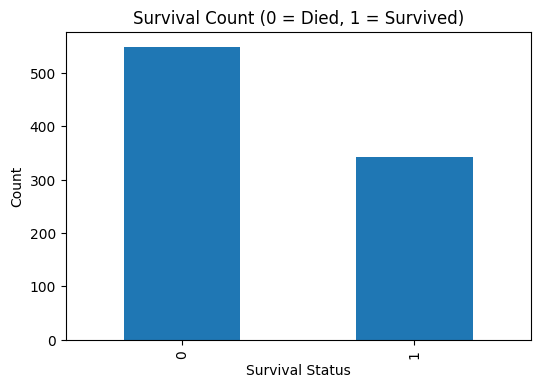

<Figure size 600x400 with 0 Axes>

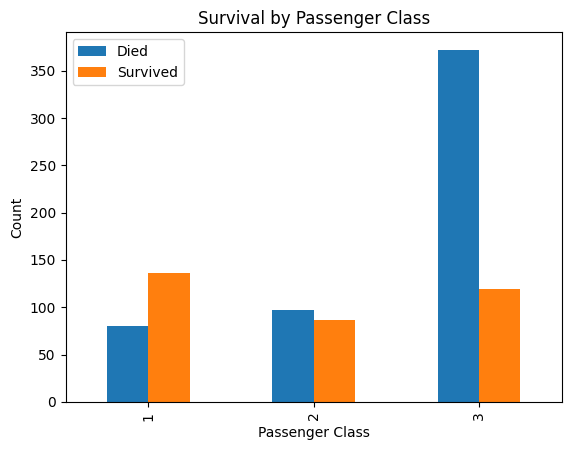

<Figure size 600x400 with 0 Axes>

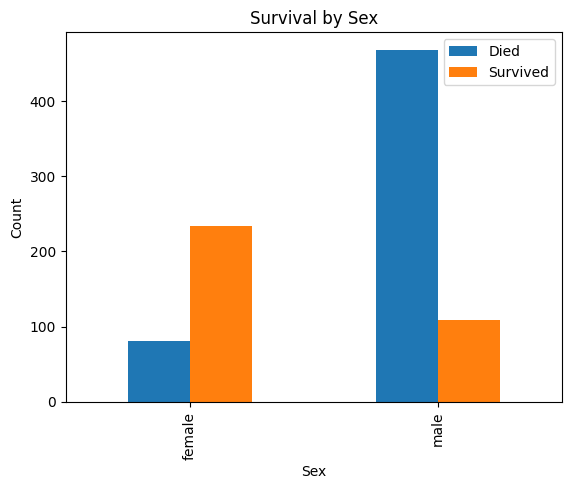

In [74]:
# Visualize survival count
plt.figure(figsize=(6, 4))
train_df['Survived'].value_counts().plot(kind='bar')
plt.title('Survival Count (0 = Died, 1 = Survived)')
plt.xlabel('Survival Status')
plt.ylabel('Count')
plt.show()

# Visualize survival by passenger class
plt.figure(figsize=(6, 4))
pd.crosstab(train_df['Pclass'], train_df['Survived']).plot(kind='bar')
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(['Died', 'Survived'])
plt.show()

# Visualize survival by sex
plt.figure(figsize=(6, 4))
pd.crosstab(train_df['Sex'], train_df['Survived']).plot(kind='bar')
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(['Died', 'Survived'])
plt.show()

## 2. Data Preprocessing

Now cleaning the input and conversion of text data to numbers shall be done.

**Steps:**  
1. Handle missing values (Age, Fare, Embarked)  
2. Convert categorical features (Sex, Embarked) to numerical  
3. Drop irrelevant columns (PassengerId, Name, Ticket, Cabin)  


In [75]:
def preprocess_data(df):
    df = df.copy()

    # Handle missing values with grouped medians
    # Use transform instead of apply to maintain the original index
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Create new features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Extract and clean titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                    'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Convert categories to numbers
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    df['Title'] = df['Title'].map({'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4})

    # Remove unused columns
    df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, inplace=True)

    return df

In [76]:
def scale_features(X_train, X_test):
    """Scale features to have mean=0 and std=1"""
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    std[std == 0] = 1.0  # prevent division by zero
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

## 3. Naive Bayes Implementation

Here I shall be implementing Gaussian Naive Bayes which uses the mean and variance of features for each class and applies Bayes' theorem for predictions.


In [77]:
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Initialize mean, variance, and priors
        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c, :] = X_c.mean(axis=0)
            self.var[c, :] = X_c.var(axis=0)
            self.priors[c] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

### Naive Bayes Evaluation

Now evaluation of this will be done to get:

- **Accuracy:** Percentage of correct predictions  
- **Confusion Matrix:** True vs. predicted labels  

In [78]:
# Initialize and train Naive Bayes
nb = NaiveBayes()
nb.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb.predict(X_test)

# Calculate accuracy
accuracy_nb = np.mean(y_pred_nb == y_test)
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")

# Confusion matrix
conf_matrix_nb = pd.crosstab(y_test, y_pred_nb, rownames=['Actual'], colnames=['Predicted'])
print("\nConfusion Matrix:")
print(conf_matrix_nb)

Naive Bayes Accuracy: 0.9115

Confusion Matrix:
Predicted    0    1
Actual             
0          233   33
1            4  148


## 4. K-Nearest Neighbors (KNN) Implementation

Now I shall be implementing K-Nearest Neighbors algorithm that predicts a test point's class by finding its k nearest neighbors in the training data based on Euclidean distance and selecting the majority class among them.


In [79]:
class KNN:
    def __init__(self, k=5, use_weights=True):
        self.k = k
        self.use_weights = use_weights

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        # Calculate distances to all training points
        distances = np.sqrt(np.sum((self.X_train - x)**2, axis=1))

        # Get k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
        k_labels = self.y_train[k_indices]
        k_dists = distances[k_indices]

        # Calculate votes (weighted or simple)
        if self.use_weights:
            weights = 1 / (k_dists + 1e-10)  # small constant to avoid division by zero
            votes = np.zeros(2)
            for i, label in enumerate(k_labels):
                votes[label] += weights[i]
            return np.argmax(votes)
        else:
            return np.bincount(k_labels).argmax()

### KNN Evaluation

Now evaluation of this will be done.

Testing `k` values to find the optimal one:  
- **Accuracy vs. k Plot:** Shows how performance changes with `k`  
- **Best k:** Highest accuracy value  


k= 1  Accuracy: 0.7608
k= 3  Accuracy: 0.8062
k= 5  Accuracy: 0.8230
k= 7  Accuracy: 0.8206
k= 9  Accuracy: 0.8278
k=11  Accuracy: 0.8373
k=13  Accuracy: 0.8301
k=15  Accuracy: 0.8349
k=17  Accuracy: 0.8373
k=19  Accuracy: 0.8421
k=21  Accuracy: 0.8445
k=23  Accuracy: 0.8445


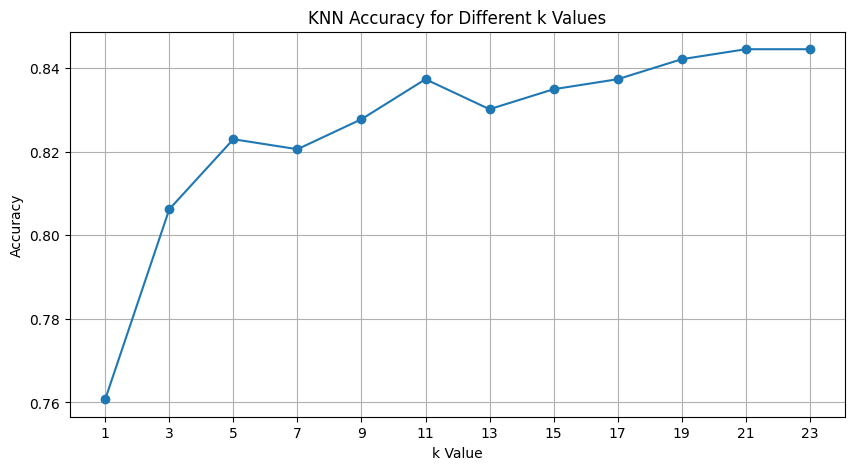


Best k: 21
Final Accuracy: 0.8445

Confusion Matrix:
Predicted    0    1
Actual             
0          230   36
1           29  123


In [80]:
# Load and prepare data
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FSM Globals BVM/titanic/gender_submission.csv')

train_clean = preprocess_data(train_data)
test_clean = preprocess_data(test_data)

X_train = train_clean.drop('Survived', axis=1).values
y_train = train_clean['Survived'].values
X_test = test_clean.values
y_test = submission['Survived'].values

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

# Find best k value
k_values = list(range(1, 25, 2))
accuracies = []

for k in k_values:
    model = KNN(k=k, use_weights=True)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    accuracy = np.mean(preds == y_test)
    accuracies.append(accuracy)
    print(f"k={k:2d}  Accuracy: {accuracy:.4f}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(k_values, accuracies, 'o-')
plt.title('KNN Accuracy for Different k Values')
plt.xlabel('k Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Final model with best k
best_k = k_values[np.argmax(accuracies)]
final_model = KNN(k=best_k, use_weights=True)
final_model.fit(X_train_scaled, y_train)
final_preds = final_model.predict(X_test_scaled)
final_accuracy = np.mean(final_preds == y_test)

print(f"\nBest k: {best_k}")
print(f"Final Accuracy: {final_accuracy:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(pd.crosstab(y_test, final_preds,
                 rownames=['Actual'],
                 colnames=['Predicted']))

## 5. Model Comparison

**Bar Plot:**  
It will compare both models knn and Gaussian naive.



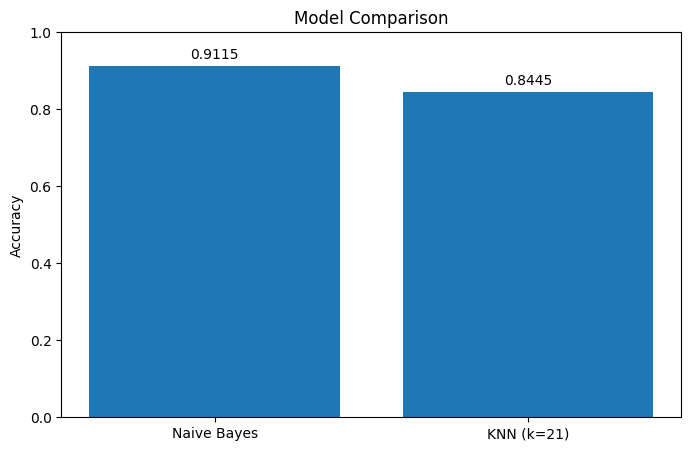


Final Results:
Naive Bayes Accuracy: 0.9115
KNN Best Accuracy (k=21): 0.8445


In [81]:
# Create comparison bar plot
plt.figure(figsize=(8, 5))
plt.bar(['Naive Bayes', f'KNN (k={best_k})'], [accuracy_nb, max(accuracies)])
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate([accuracy_nb, max(accuracies)]):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center')
plt.show()

print("\nFinal Results:")
print(f"Naive Bayes Accuracy: {accuracy_nb:.4f}")
print(f"KNN Best Accuracy (k={best_k}): {max(accuracies):.4f}")

## 6. Github Link Below

https://github.com/ShivanshSrivastava136/FSM-Assignment-1